In [91]:
# N = N_up + N_down fermions in a 1D harmonic trap, no delta function interactions
# %env XLA_PYTHON_CLIENT_PREALLOCATE=False
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform
# %env JAX_ENABLE_X64=False

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_ENABLE_X64"] = "False"

import numpy as np
import time
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import tqdm, trange
from math import factorial
import pickle

# set the default device to the cpu
jax.default_device(jax.devices("cpu")[0])
jax.config.update('jax_platform_name', 'cpu')

#use pickle to save the parameters to a file 
def save_params(params, filename):
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
# use pickle to dump the energies and uncertainties to a file
def save_energies(hs, us, filename):
    with open(filename, 'wb') as f:
        pickle.dump((hs, us), f)

# use pickle to load the parameters from a file
def load_params(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)    
# use pickle to load the energies and uncertainties from a file
def load_energies(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def compute_true_energy():
    ret = N_up**2 + N_down**2
    return ret/2

##### Constants
N_up = 9
N_down = 9
N = N_up + N_down


# FACT_UP = 1/np.sqrt(factorial(N_up))
FACT_UP = 1/5
# FACT_DOWN = 1/np.sqrt(factorial(N_down))
FACT_DOWN = 1/5
SYM_DEN = 3
GPU_INDEX = 1
# division factor in the ansatz
DIV = 2.5
INITIAL_SAMPLE = jnp.array(np.random.uniform(-2, 2, N))
phi_structure = [50,50]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1

#######

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases



network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up]
    sym_piece2 = reordered[N_up:]

    new1 = []
    new2 = []
    for i in range(1, N_up):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down+1):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1]
    sym_piece2 = reordered[N_up + 1:]
    
    new1 = []
    new2 = []
    for i in range(1, N_up+1):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
        
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN
@jit
def psi(coords, params):
    return  Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum((coords/DIV)**2))


@jit
def mcstep_E(xis, limit, positions, params):
    
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    newpositions = jnp.array(positions) + xis
    
    prob = psi(newpositions, params)**2./psi(positions, params)**2.
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

def sample(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=jnp.array(np.random.uniform(-1, 1, N)), progress=False):
    sq = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    params = jax.device_put(params, device=jax.devices("cpu")[0])

    randoms = np.random.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = np.random.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new

    return jnp.array(sq), counter/num_total


psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))

@jit
def Hpsi(coords, params):
    return jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params)

vhpsi = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0)) 

@jit
def grad_helper(coords, params):
    return jnp.sum((m*.5*omega**2*coords**2))*psi(coords, params) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params))

vgrad_helper = jit(vmap(grad_helper, in_axes=(0, None), out_axes=0))

# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))

@jit
def grad_comp(s, params, psiHpsi, energy_calc):
    return (1/psi(s, params) * dnn_dtheta(s, params)) * (psiHpsi - energy_calc) 

vgrad_comp = vmap(grad_comp, in_axes=(0, None, 0, None), out_axes = 0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    samples,_= sample(params, num_samples, thermal, skip, variation_size)

#     samples = jax.device_put(samples, device=jax.devices("gpu")[GPU_INDEX])
#     params = jax.device_put(params, device=jax.devices("gpu")[GPU_INDEX])
    
    # compute the energy 
    psiHpsi = vhpsi(samples, params) 
    energy_calc = 1/num_samples * jnp.sum(psiHpsi)
    # compute the uncertainty in the energy
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples) 

    # gradient computation
    grads = vgrad_comp(samples, params, psiHpsi, energy_calc)
    gradient_calc = 2/num_samples * jnp.sum(grads, axis=0)
    return gradient_calc, energy_calc, uncert


def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
        save_energies(hs, us, "energies.pkl")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
        # # check if the energy is oscillating around a certain value
        # if step_num > 20 and is_oscillating(hs, 20, 0.01):
        #     print("Energy is oscillating, stopping...")
        #     break
    clear_output(wait=True)
    return hs, us, ns, old_params


In [92]:
print(compute_true_energy())
# clear the energies.pkl file
save_energies([], [], "energies.pkl")

81.0


In [93]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

63918


In [94]:
def step_size(params, start):
    print("Searching for step size...")
    lr = .5
    target = 0.5
    last_acc = 0  # Store the last acceptance rate
    # sample at the starting value
    _, acc = sample(params, 800, 100, 10, start)
    # we accept the step size if the acceptance rate is within 0.05 of the target
    while acc < target - 0.05 or acc > target + 0.05:
        # If we have a last_acc and the direction of update changes, reduce lr
        if last_acc is not None:
            if (last_acc < target and acc > target) or (last_acc > target and acc < target):
                lr *= 0.5  # Reduce learning rate by half when it overshoots
        # move in the direction of the target acceptance rate
        if last_acc > acc:
            start -= lr
        else:
            start += lr
        last_acc = acc  # Update last_acc with the current acc before the next sample
        print(start, acc)
        _, acc = sample(params, 800, 100, 10, start)
    return start



def is_oscillating(values, N, tolerance=0.1):
    # Extract the last N values
    last_values = values[-N:]
    mean_value = sum(last_values) / N
    
    # Determine if values are oscillating around the mean
    signs = []
    for value in last_values:
        if abs(value - mean_value) > tolerance:  # Only consider significant deviations
            signs.append(value > mean_value)
    
    # Check if the sign alternates, indicating oscillation
    for i in range(1, len(signs)):
        if signs[i] == signs[i-1]:  # No oscillation if two consecutive signs are the same
            return False
    
    return True if len(signs) > 1 else False  # Requires at least one oscillation


In [104]:
_, ratio = sample(params, 10**3, 500, 10, 7, progress=True)
print(ratio)

MC: 100%|██████████| 10501/10501 [00:02<00:00, 3740.64it/s]


0.00095229025807066


MC: 100%|██████████| 10501/10501 [00:02<00:00, 3780.60it/s]


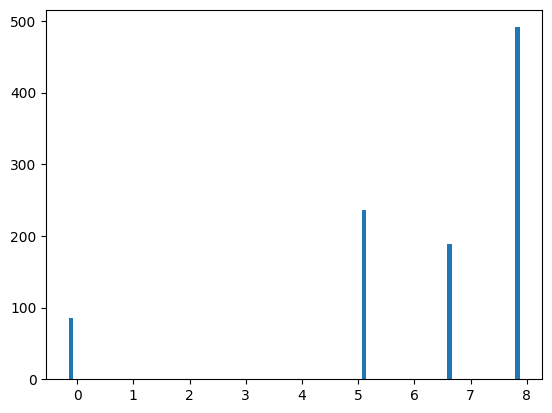

In [100]:
#histogram the first coordinate of the samples
samples, _ = sample(params, 10**3, 500, 10, 10, progress=True)
plt.hist(samples[:,0], bins=100)
plt.show()


In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-2))
resultsa = train(params, 400, 1000, 500, 10, step_size(params, 10))

In [ ]:
_, ratio = sample(params, 10**3, 500, 1, 2.3, progress=True)
print(ratio)

In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-3))
resultsb = train(resultsa[3], 2000, 1000, 500, 10, step_size(resultsa[3], 10))

In [ ]:
resultsc = train(resultsb[3], 500, 1400, 500, 1, .03)

In [ ]:
resultsd = train(resultsc[3], 10, 5000, 500, 1, .03)

In [ ]:
params = resultsa[3] 
num_final_samples = 15000
params = jax.device_put(params, device=jax.devices("cpu")[0])
samples, _= sample(params, num_final_samples, 1000, 1, .1)

In [ ]:
psiHpsi = vhpsi(samples, params)
mean_energy = 1/num_final_samples * jnp.sum(psiHpsi)

In [ ]:
print(mean_energy)
print(np.std(psiHpsi)/np.sqrt(num_final_samples))

In [ ]:
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts

energies = psiHpsi

# bins = np.linspace(1, 100, 100, dtype=int)
bins = np.array([1,2,5,10,20,50,100,150,200,250,300,360,450,500,550,600,660,750,900,990,1100])
# now plot the average energy as a function of the number of bins
us = []
for b_size in bins:
    us.append(bin_samples(energies, b_size))
plt.scatter(bins, us)
plt.title("Bin size vs. Uncertainty")
plt.xlabel("Bin size")
plt.ylabel("Uncertainty")
print(max(us))
plt.show()

In [ ]:
final = gv.gvar(mean_energy, max(us))
print(final)

In [ ]:
true_energy = compute_true_energy()

total_hists =  resultsa[0] 
# + resultsb[0] + resultsc[0]  + resultsd[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] 
# + resultsb[1] + resultsc[1] + resultsd[1]
#+ resultsd[1] 
# + resultse[1]
# + resultsd[1]

# total_hists = jax.device_put(total_hists, device=jax.devices("cpu")[0])


# get index of minimum value

plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam: " + str(final))
# plt.xlim(1000, 1050)
# plt.ylim(30, 50)
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (final - true_energy)/true_energy*100
# plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title(str(N) + " Fermions, "+ str(N_up) + " Up, "+str(N_down)+" Down")
plt.show()